# Human RNA editing landscape of REDIportal (GPU-based)

### Part II-2 Clustering all 21-mers feature of non-repeatative editing sites in REDIportal (Human, hg38)

### (Load UMAP results and analyze with HDBSCAN in CPU mode)
---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

## Hardware

- Sytem: Ubuntu 18.04.5 LTS
- CPU: Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz (12 cores)
- Disk: SAMSUNG MZ7LH960HAJR-00005 (SSD)
- RAM: 64G(32Gx2) DDR4 2666MHz
- GPU: RTX2080Ti (Driver Version: 495.29.05, CUDA Version: 11.5)

## Container Environment

**RAPIDS 21.12** (see https://rapids.ai/start.html)
- Ubuntu 20.04
- All packages
- Python 3.8
- CUDA 11.5

## 0. Configure the environment

In [1]:
import numpy as np
import pandas as pd
import hdbscan
from sklearn.preprocessing import OneHotEncoder
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tracemalloc
import scipy.stats
import os

tracemalloc.start()

import time
time0 = time.time()

In [2]:
def get_table_and_onehot(fn, REP_level=None):
    onehot_input = []
    
    df = pd.read_csv(fn, index_col=0, header=0)
    if REP_level is not None:
        df = df.loc[df["type"]==REP_level]
    print(df.shape)
    
    for seq in df["motif_F10"]:
            onehot_input.append(onehot_enc(seq))
    onehot_input = np.array(onehot_input)
    print(onehot_input.shape)
    
    return df, onehot_input

In [3]:
def cluster_HDBSCAN(df, min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom'):
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    time0 = time.time()
    
    model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon, cluster_selection_method=cluster_selection_method, core_dist_n_jobs=8, prediction_data=False)
    yhat = model.fit(X)
    
    # soft_clusters = hdbscan.all_points_membership_vectors(yhat)
    # labels = [np.argmax(x) for x in soft_clusters] 
    labels = yhat.labels_
    time1 = time.time() - time0
    
    df["Cluster"] = [i+1 if i > -1 else -1 for i in labels ]  # re-number lables to make it human-readable
    
    print("HDBSCAN time: {} sec".format(time1))
    print("Cluster number: {}".format(df["Cluster"].max()))
    print("==================================================")
    # check cluster number
    print(df.groupby("Cluster")["Cluster"].count())
    return df

In [4]:
def draw_one_sample(ax, df, title=None, cluster_col="Cluster", s=0.2, alpha=1.0, draw_contour=False):
    clusters = {}
    for i in df[cluster_col]:
        clusters[i] = 1
    clusters = clusters.keys()
    
    for i in clusters:
        subdf = df[df[cluster_col]==i]
        if i <= -1:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=12) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # draw density
    if draw_contour == True:
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([df["X"], df["Y"]])
        kernel = scipy.stats.gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)
        c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)

In [5]:
def subcluster_HDBSCAN_softclustering(df, target=None, cluster_col="Cluster", min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom', draw_condensed_tree=False, soft_clustering=True, unclassified=-1):
    # use multi-code here
    df = df.copy()
    max_cluster_id = df[cluster_col].max()
    
    df1 = df[df[cluster_col]==target].copy()
    
    X = np.stack([df1["X"], df1["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    if soft_clustering == True:
        prediction_data = True
    else:
        prediction_data = False
        
    model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_method=cluster_selection_method, core_dist_n_jobs=8, prediction_data=prediction_data, cluster_selection_epsilon=cluster_selection_epsilon)
    yhat = model.fit(X)
    if soft_clustering == True:
        soft_clusters = hdbscan.all_points_membership_vectors(yhat)
        labels = [np.argmax(x) for x in soft_clusters] 
    else:
        labels = yhat.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df1[cluster_col] = [max_cluster_id + i + 1 if i > -1 else unclassified for i in labels ]  # re-number lables to make it human-readable
    df.loc[df1.index, cluster_col] = df1[cluster_col].tolist()
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    # print("==================================================")
    # check cluster number
    print(df.groupby(cluster_col)[cluster_col].count())
    if draw_condensed_tree == True:
        fig, ax = plt.subplots()
        model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    return time1, mem, df, model

In [6]:
def extract_fasta_and_draw_motifs(prefix, df, cluster_col="Cluster", filter=None, motif_column="motif_F10", draw_logos=True):
    print("===============  {} ===============".format(prefix))
    if os.path.isdir("{}".format(prefix)) == False:
        os.mkdir("./{}".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    else:
        os.system("rm -r ./{}/*".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    if filter is not None:
        df = df[df[filter] == True].copy()
    clusters = set(df[cluster_col].tolist())
    for g in clusters:
        subdf = df[df[cluster_col] == g]
        with open("./{}/fasta/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column].replace("T", "U")))  # to RNA bases
                N += 1
            print("Cluster #{}: {}".format(g, N))
    if draw_logos == True:
        for g in clusters:
            os.system("weblogo -A rna -D fasta -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_png/cluster_{g}.png".format(prefix=prefix, g=g))

            os.system("weblogo -A rna -D fasta -F pdf -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq_png/cluster_{g}.png".format(prefix=prefix, g=g)) 
            
            os.system("weblogo -A rna -D fasta -X no -Y no -P \"\" -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_no_axis/cluster_{g}.pdf".format(prefix=prefix, g=g))

In [7]:
def show_logos_cols(prefix, names=None, cols=2, figsize=(8,8), auto_size=True):
    file_list = []
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        file_list.append(img)
    
    file_list_format = []
    for i in file_list:
        id = int(i.replace("cluster_", "").replace(".png", ""))
        file_list_format.append((i, id))
    file_list_format = sorted(file_list_format, key=lambda x:x[1]) 
    
    if len(file_list_format) % cols == 0:
        rows = len(file_list_format) // cols
    else:
        rows = len(file_list_format) // cols + 1
    if auto_size == False:
        figsize = figsize
    else:
        width = 4 * cols
        height = 1.5 * rows
        figsize = (width, height)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, image in zip(*[axes.reshape(-1), file_list_format]):
        fn, id = image
        img = plt.imread(prefix+"/"+fn)
        _ = ax.imshow(img)
        ax.set_title("cluster_{}".format(id))
    for ax in axes.reshape(-1):
        ax.axis("off")
    plt.tight_layout()

## 1. Load data from deduplicated table

In [8]:
# load table if already have
df_all = pd.read_csv("./REDIportal_hg38.F10.NONREP.retrived.UMAP.csv", index_col=0, header=0)

## 2. HDBSCAN

In [9]:
df_all = cluster_HDBSCAN(df_all, min_cluster_size=30, min_samples=5, cluster_selection_method="eom", cluster_selection_epsilon=0.035)

HDBSCAN time: 41.52895450592041 sec
Cluster number: 21
Cluster
-1       2638
 1         95
 2        131
 3         48
 4        231
 5         38
 6         39
 7         99
 8        102
 9         86
 10       101
 11       162
 12        33
 13       231
 14       355
 15        49
 16        63
 17        46
 18        88
 19       248
 20      4086
 21    443594
Name: Cluster, dtype: int64


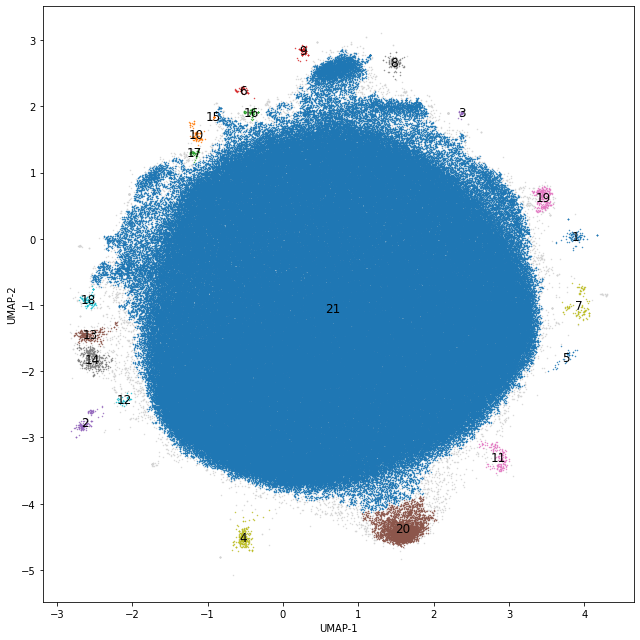

In [10]:
fig, ax = plt.subplots(figsize=(9, 9))
draw_one_sample(ax, df_all)
plt.tight_layout()

**Continue to split Cluster \#27**

In [11]:
_, _, df_all_2, _ = subcluster_HDBSCAN_softclustering(df_all, target=21, cluster_col="Cluster", min_cluster_size=30, min_samples=10, cluster_selection_epsilon=0.0225, cluster_selection_method='eom', draw_condensed_tree=False, soft_clustering=False, unclassified=-2)

HDBSCAN soft clustering time: 54.32379770278931 sec
HDBSCAN soft clustering RAM: 203.41510391235352 Mb
HDBSCAN cluster number: 86
Cluster
-2      14156
-1       2638
 1         95
 2        131
 3         48
        ...  
 82        52
 83       158
 84        69
 85    421019
 86       676
Name: Cluster, Length: 87, dtype: int64


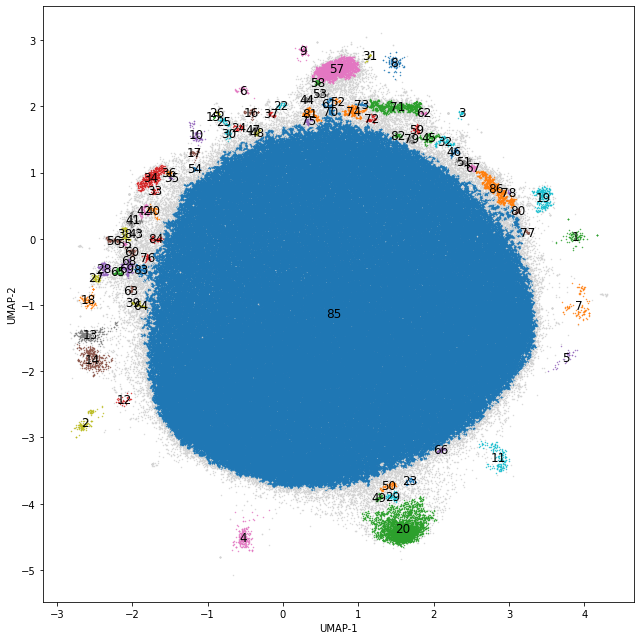

In [12]:
fig, ax = plt.subplots(figsize=(9, 9))
draw_one_sample(ax, df_all_2)
plt.tight_layout()

**We shoud install weblgo first. (The following codes are used for docker only.)**

In [13]:
extract_fasta_and_draw_motifs("NONREP_clusters_CPU", df_all_2)

===============  NONREP_clusters_CPU ===============
Cluster #1: 95
Cluster #2: 131
Cluster #3: 48
Cluster #4: 231
Cluster #5: 38
Cluster #6: 39
Cluster #7: 99
Cluster #8: 102
Cluster #9: 86
Cluster #10: 101
Cluster #11: 162
Cluster #12: 33
Cluster #13: 231
Cluster #14: 355
Cluster #15: 49
Cluster #16: 63
Cluster #17: 46
Cluster #18: 88
Cluster #19: 248
Cluster #20: 4086
Cluster #22: 31
Cluster #23: 39
Cluster #24: 43
Cluster #25: 49
Cluster #26: 64
Cluster #27: 55
Cluster #28: 117
Cluster #29: 75
Cluster #30: 31
Cluster #31: 45
Cluster #32: 92
Cluster #33: 99
Cluster #34: 469
Cluster #35: 41
Cluster #36: 45
Cluster #37: 58
Cluster #38: 65
Cluster #39: 50
Cluster #40: 54
Cluster #41: 97
Cluster #42: 72
Cluster #43: 44
Cluster #44: 91
Cluster #45: 134
Cluster #46: 48
Cluster #47: 38
Cluster #48: 30
Cluster #49: 38
Cluster #50: 73
Cluster #51: 82
Cluster #52: 38
Cluster #53: 84
Cluster #54: 37
Cluster #55: 138
Cluster #56: 65
Cluster #57: 2358
Cluster #58: 30
Cluster #59: 45
Cluster #60:

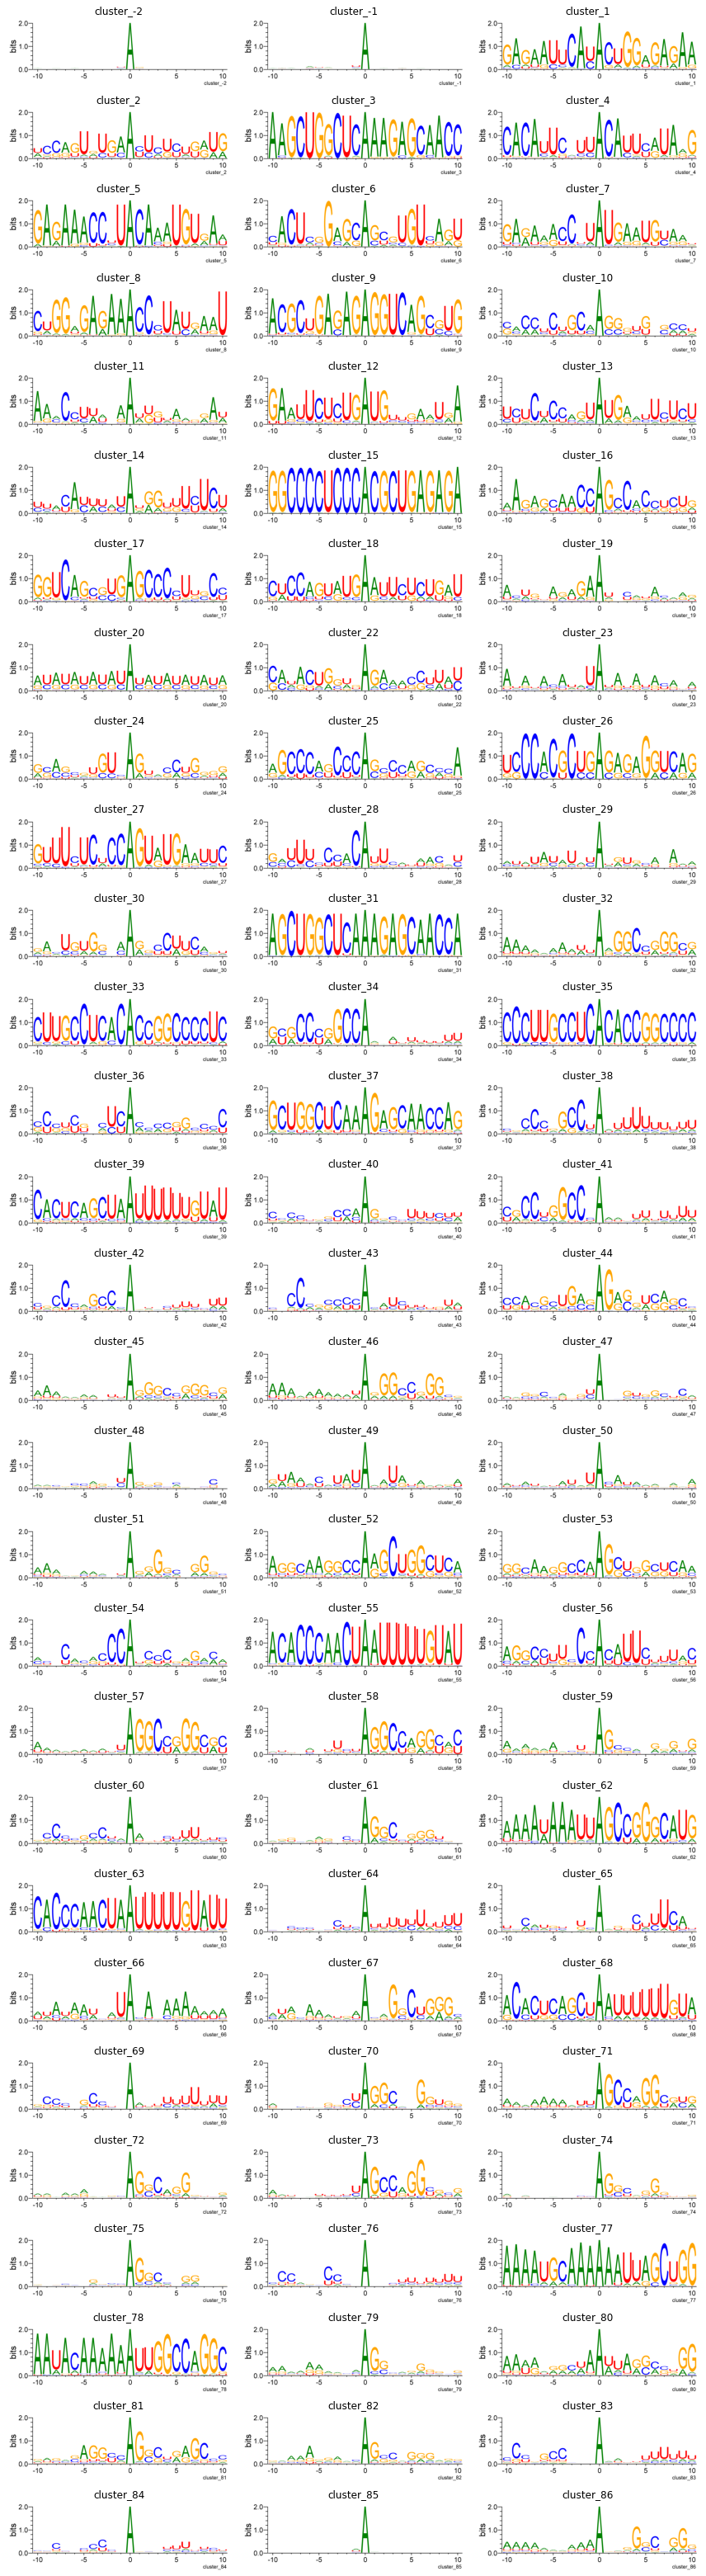

In [14]:
show_logos_cols("./NONREP_clusters_CPU/logos_bits_png/", cols=3)